In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score, RandomizedSearchCV, cross_validate

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

per_gop  per_dem  per_third_party   County_with_State        Date  \
0     71.4     27.0              1.5  Autauga County, AL  05/10/2023   
1     76.2     22.4              1.4  Baldwin County, AL  05/10/2023   
2     53.5     45.8              0.8  Barbour County, AL  05/10/2023   
3     78.4     20.7              0.9     Bibb County, AL  05/10/2023   
4     89.6      9.6              0.9   Blount County, AL  05/10/2023   

   Series_Complete_Pop_Pct  Metro_status  PCTPOVALL_2021  MEDHHINC_2021    WA  \
0                     46.1             1              10          66444  74.8   
1                     53.4             1              10          65658  87.4   
2                     47.4             0              23          38649  49.2   
3                     36.5             1              20          48454  76.5   
4                     32.9             1              12          56894  95.4   

     BA   IA  AAPI  MEDIAN_AGE_TOT  through_hs  college_up  target  
0  21.4  0.5   1.3            39.2        43.2        56.8       0  
1   8.4  0.8   1.2            44.1        36.4        63.6       0  
2  47.7  0.7   0.7            41.5        61.0        39.0       0  
3  21.0  0.6   0.4            40.9        63.4        36.6       0  
4   1.9  0.6   0.6            41.2        51.5        48.5       0

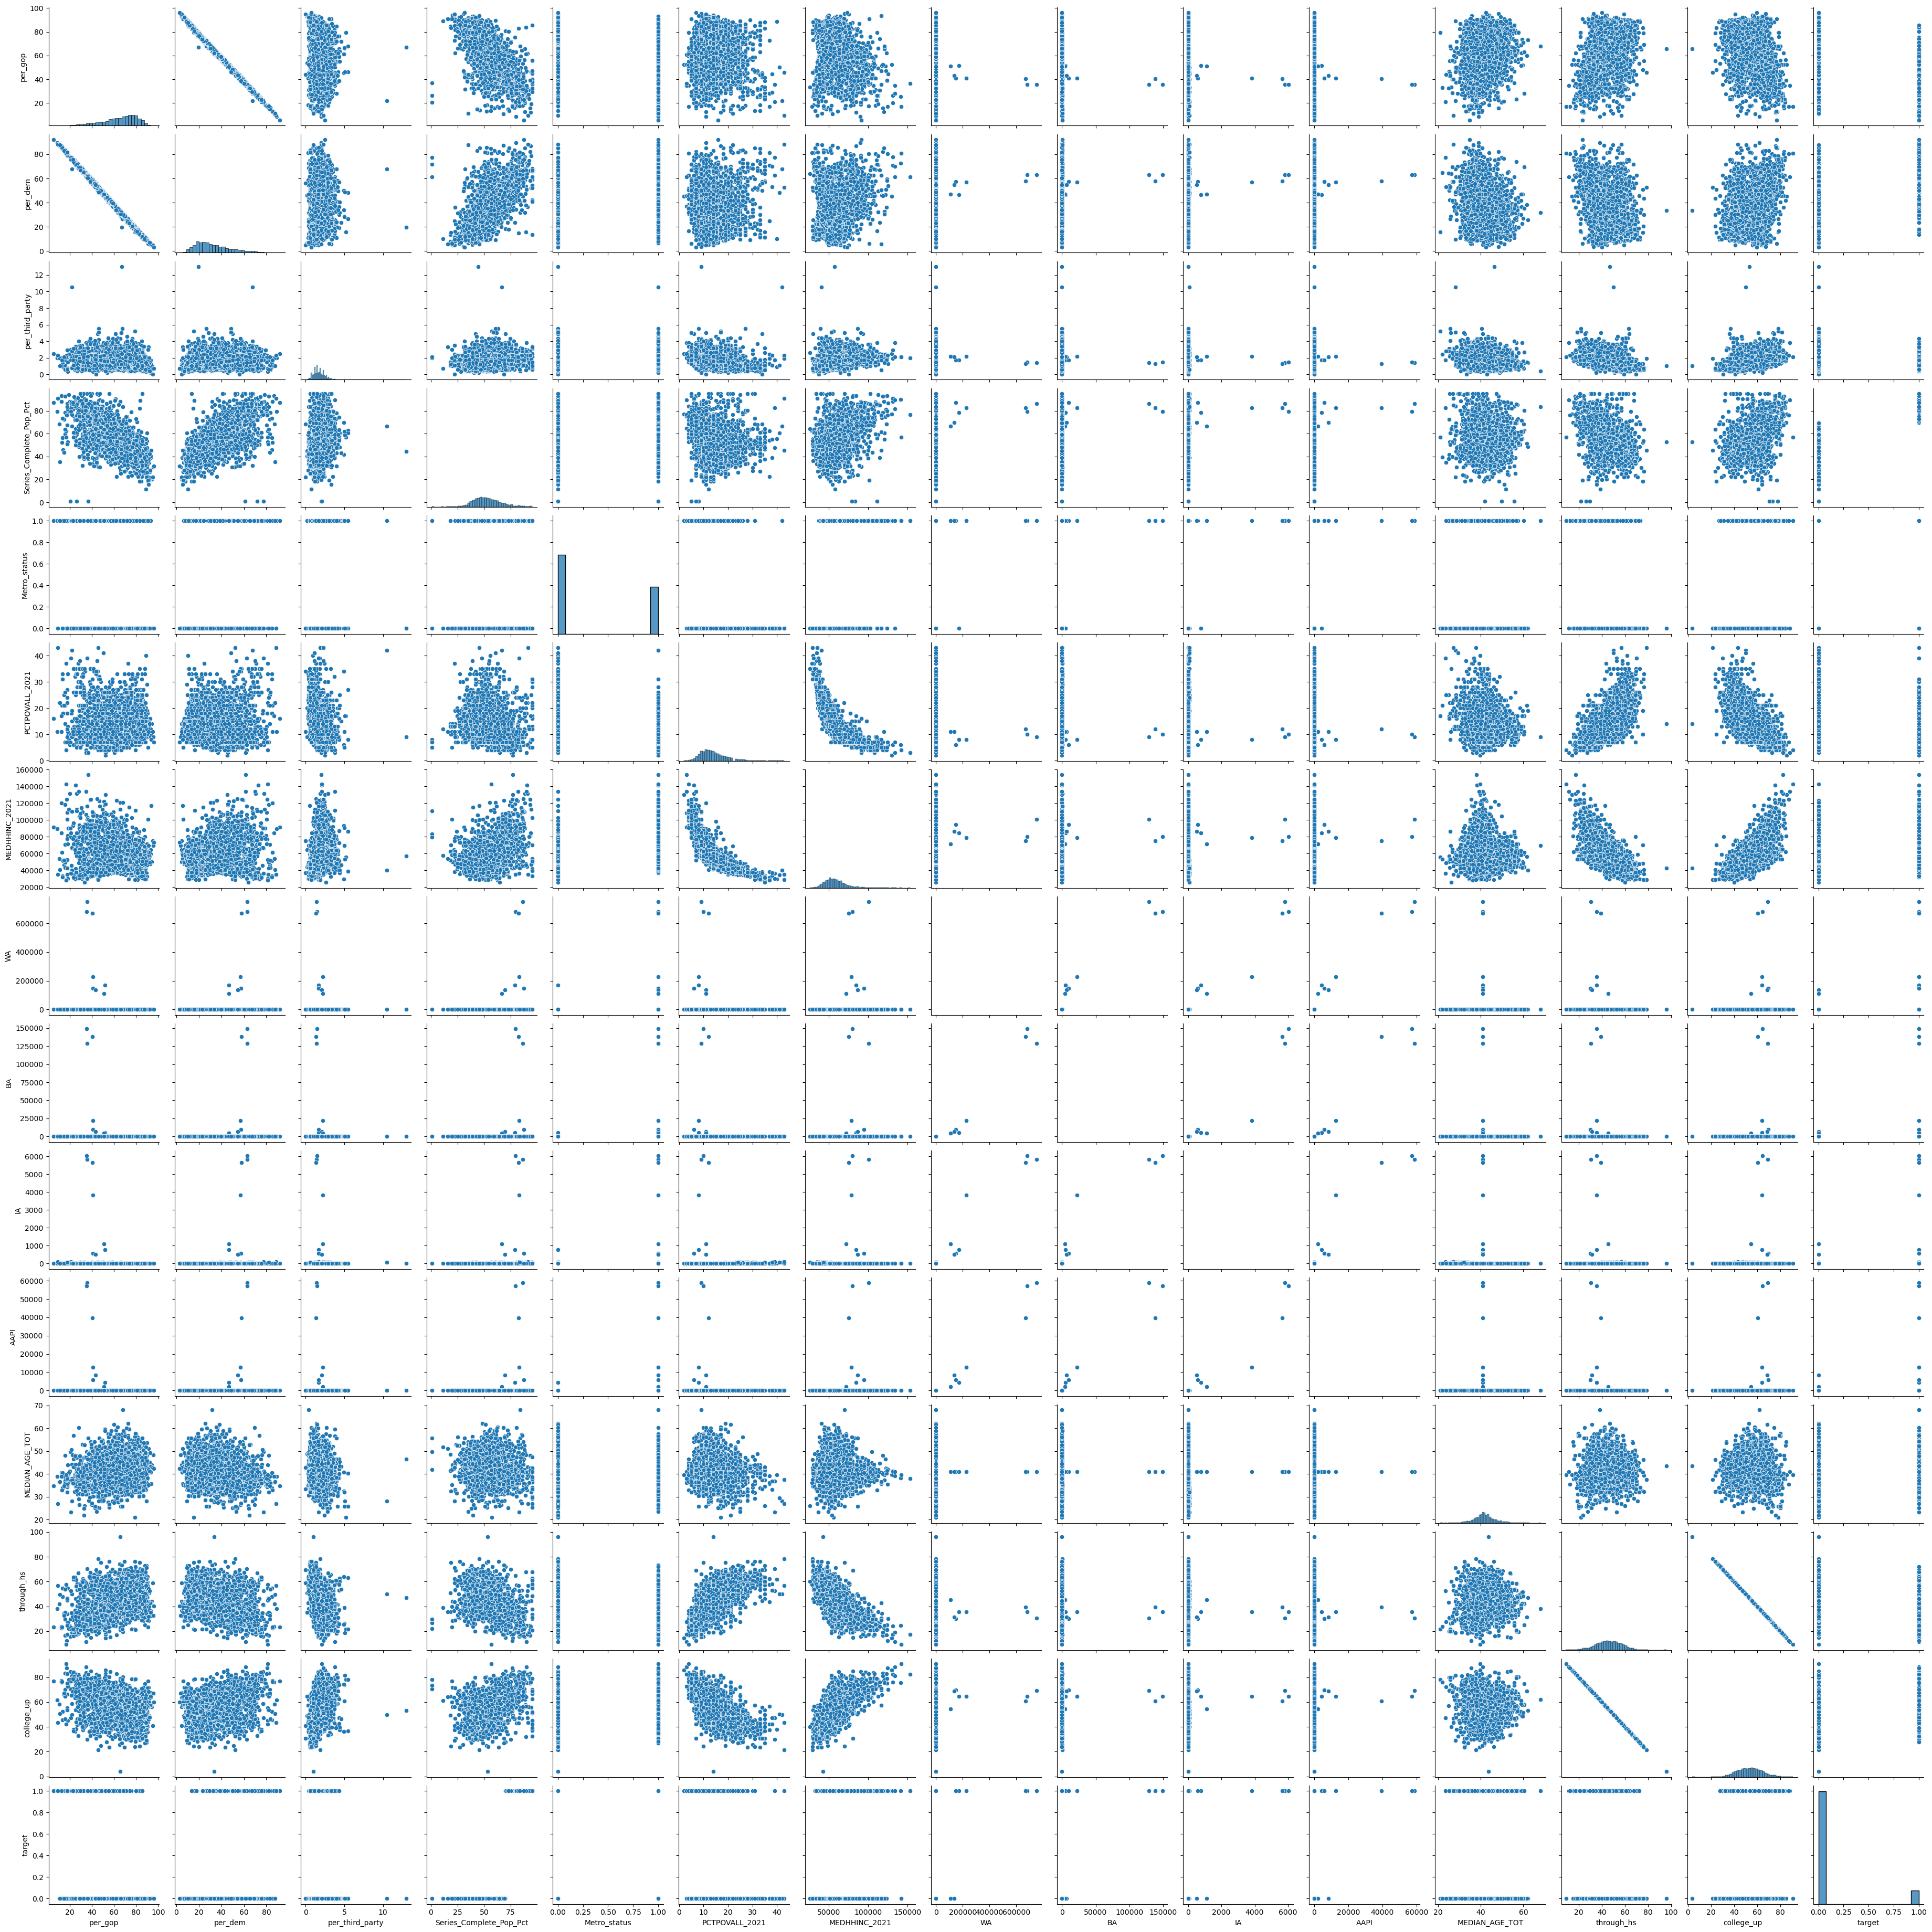

In [4]:
sns.pairplot(df)


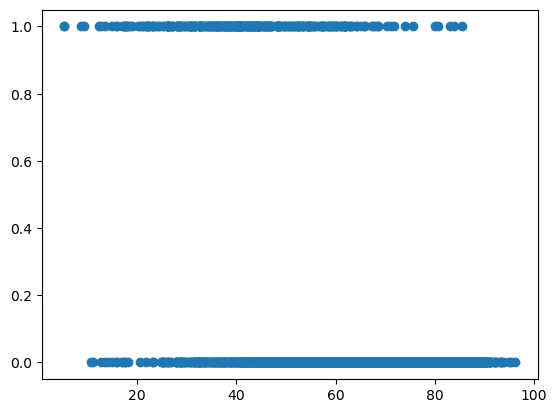

In [6]:
plt.scatter(df['per_gop'], df['target'])

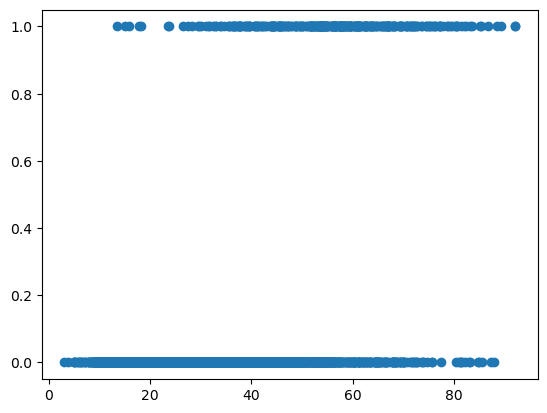

In [7]:
plt.scatter(df['per_dem'], df['target'])

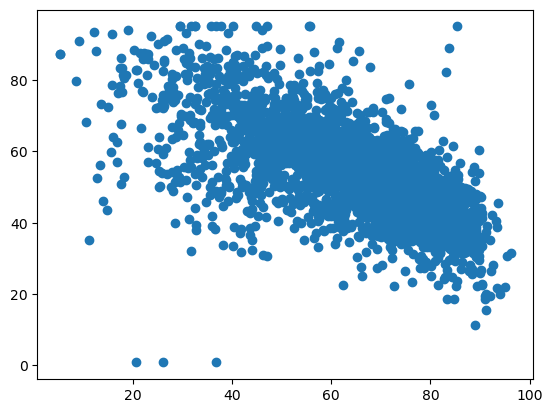

In [11]:
plt.scatter(df['per_gop'], df['Series_Complete_Pop_Pct'])

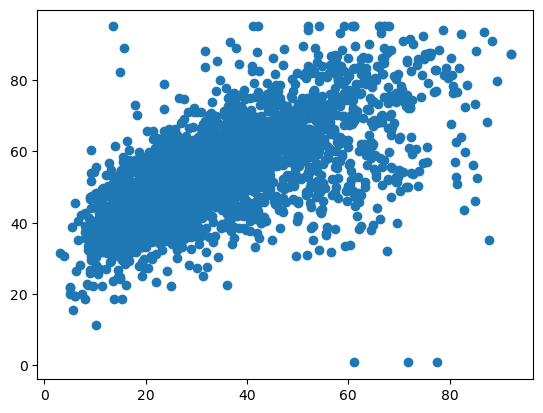

In [12]:
plt.scatter(df['per_dem'], df['Series_Complete_Pop_Pct'])

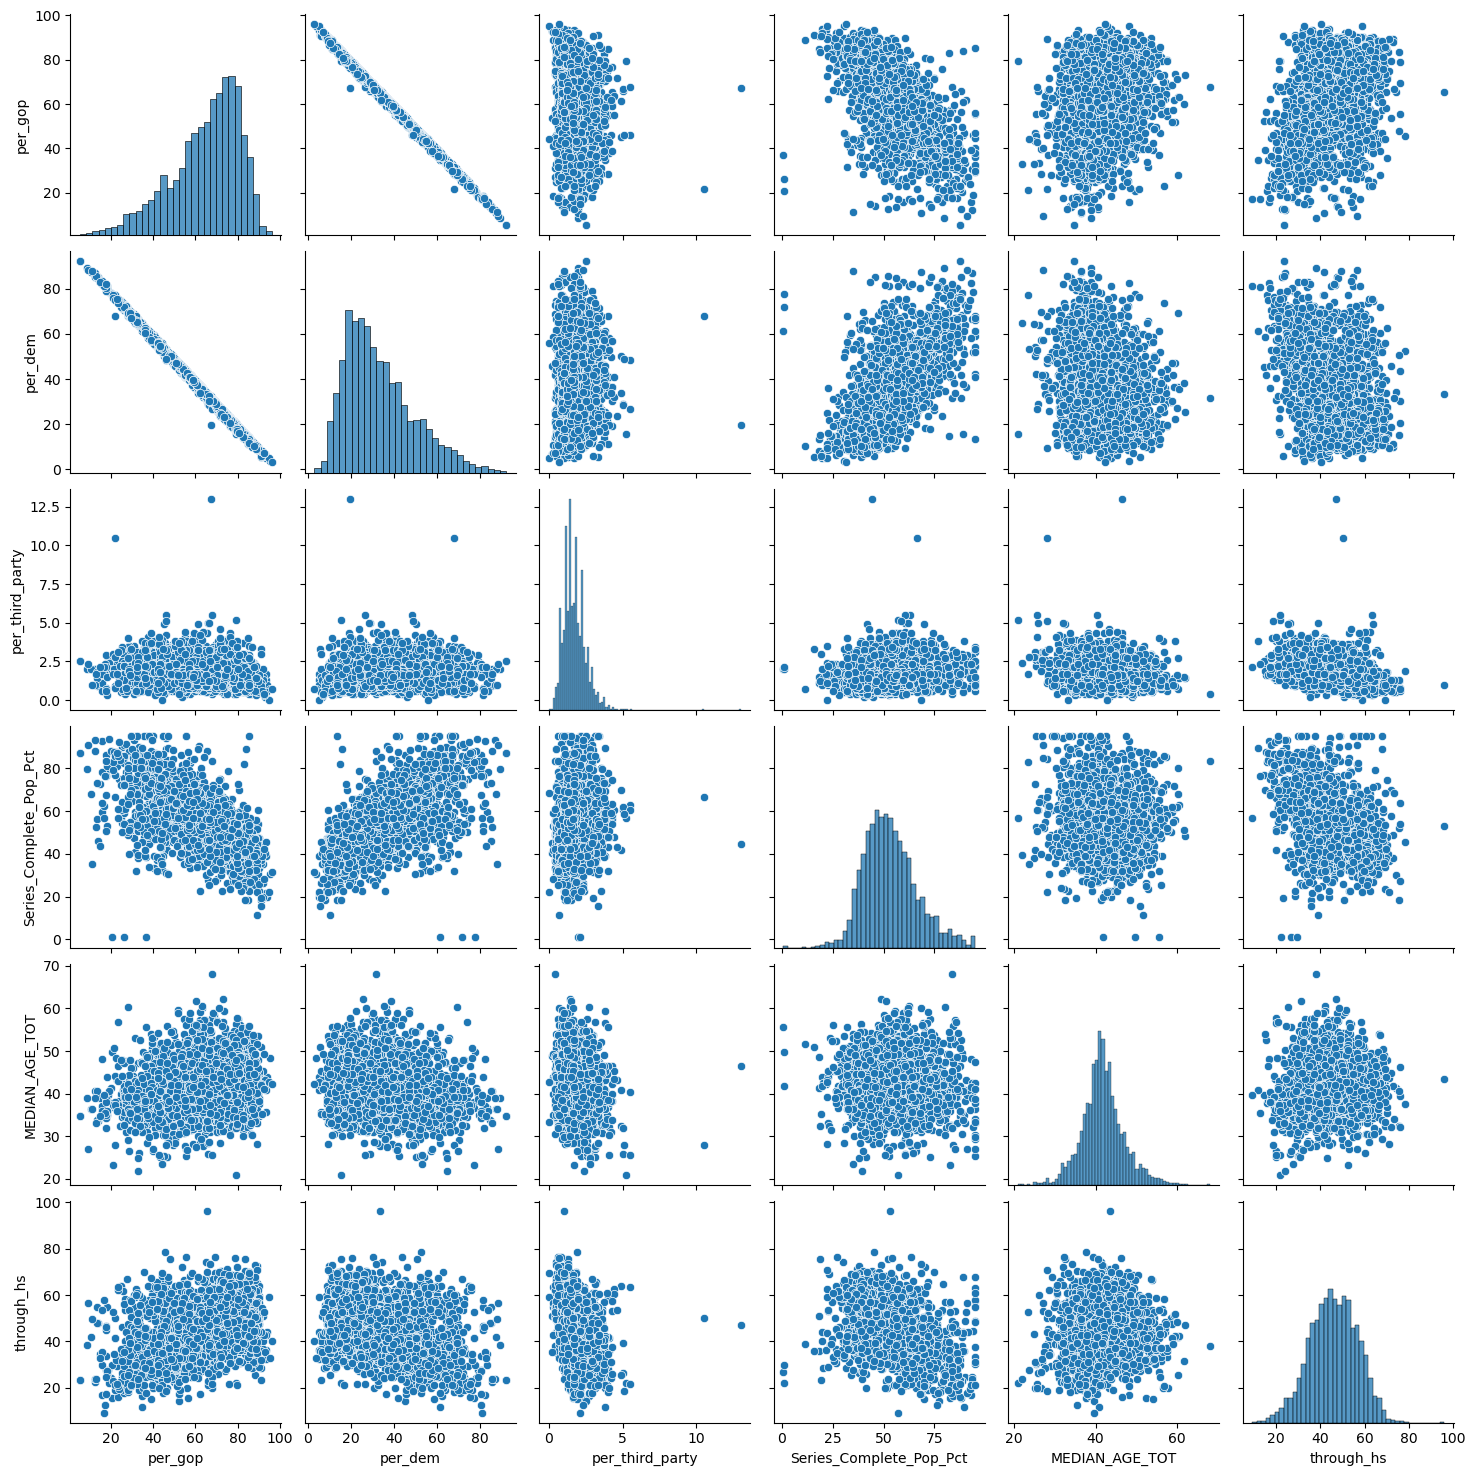

In [13]:
continuous = ["per_gop", "per_dem", "per_third_party", "Series_Complete_Pop_Pct", "MEDIAN_AGE_TOT", "through_hs"]
sns.pairplot(df, vars=continuous)

# SMOTE

In [3]:
y = df['target']
X = df.drop(columns=['target', 'Series_Complete_Pop_Pct', 'County_with_State', "Date"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

In [4]:
y_train.value_counts(normalize=True)

target
0    0.894173
1    0.105827
Name: proportion, dtype: float64

In [5]:
sm = SMOTE(random_state=42, sampling_strategy="minority", k_neighbors=10)
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train_scaled, y_train)
y_tr_sm.value_counts()

target
0    2087
1    2087
Name: count, dtype: int64

In [17]:
logreg_smote = LogisticRegression(random_state=1, max_iter=1000, penalty='l2', C=1e5)
logreg_smote.fit(X_tr_sm, y_tr_sm)

# Predict on training set

logreg_smote.score(X_train_scaled, y_train)



0.8817480719794345

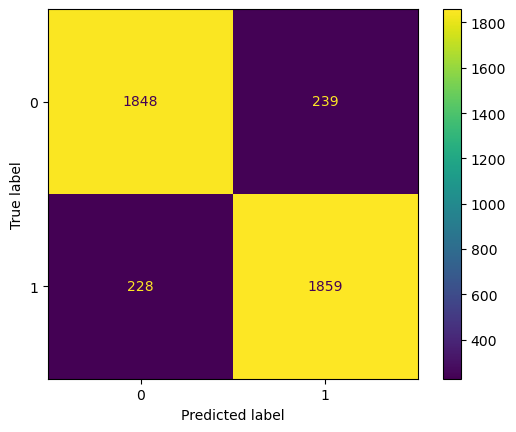

In [18]:
cm = confusion_matrix(y_tr_sm, logreg_smote.predict(X_tr_sm))
ConfusionMatrixDisplay(cm).plot()

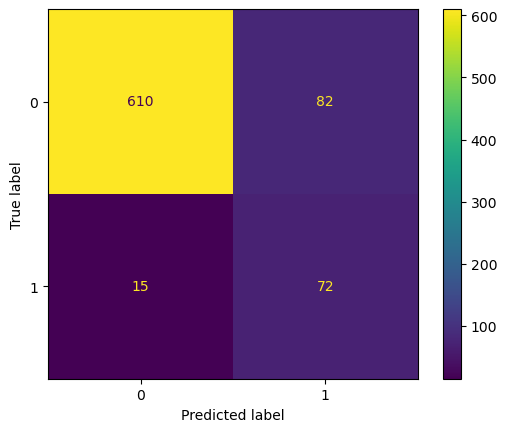

In [19]:
ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_smote.predict(X_test_scaled))).plot();

In [20]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_tr_sm, y_tr_sm)
dt.score(X_tr_sm, y_tr_sm)


1.0

In [21]:
y_pred = dt.predict(X_test_scaled)
dt.score(X_test_scaled, y_test)



0.8793324775353016

# Pipeline

In [26]:
from imblearn.pipeline import Pipeline

y = df['target']
X = df.drop(columns=['target', 'Series_Complete_Pop_Pct', 'County_with_State', "Date"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy="minority", k_neighbors=10)),
    ('dt', DecisionTreeClassifier(random_state=1))
])

pipe.fit(X_train, y_train)

list(zip(pipe['dt'].feature_importances_, X_train.columns))


[(0.5374474426634323, 'per_gop'),
 (0.03656748982891745, 'per_dem'),
 (0.028879434564636895, 'per_third_party'),
 (0.002943885589625507, 'Metro_status'),
 (0.040366034247163625, 'PCTPOVALL_2021'),
 (0.03498311032987577, 'MEDHHINC_2021'),
 (0.0136279592286496, 'WA'),
 (0.06556846727596034, 'BA'),
 (0.06452256106621798, 'IA'),
 (0.06442887898233957, 'AAPI'),
 (0.05160628904251607, 'MEDIAN_AGE_TOT'),
 (0.01134959018842597, 'through_hs'),
 (0.047708856992238896, 'college_up')]

In [28]:
pipe_grid = {'smote__k_neighbors': [5, 10, 20],
                'dt__max_depth': [None, 1, 5, 10],
                'dt__min_samples_split': [2, 5, 10],
                'dt__min_samples_leaf': [1, 2, 5, 10],
                'dt__ccp_alpha': [0, .001, .01, .1, 1]}

gs_pipe = GridSearchCV(pipe, pipe_grid, cv=5, verbose=2, scoring=['accuracy', 'recall', 'precision'], refit='precision')



In [29]:
gs_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=0, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; t

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=N

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, 

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=N

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_dept

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_de

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=Non

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=N

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_de

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=No

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None,

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=N

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=N

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_dept

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_de

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_d

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, d

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_lea

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_sample

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2,

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5,

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_lea

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_sample

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=1, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_lea

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samp

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_l

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_lea

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samp

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_sampl

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_sa

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sample

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sam

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sam

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samp

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sam

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_s

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=2, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sample

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sampl

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samp

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_sam

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_s

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=5; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=10; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, smote__k_neighbors=20; total time=   0.0s
[CV] END dt__ccp_alpha=1, dt__max_depth=10

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(k_neighbors=10, random_state=42,
                                              sampling_strategy='minority')),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=1))]),
             param_grid={'dt__ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                         'dt__max_depth': [None, 1, 5, 10],
                         'dt__min_samples_leaf': [1, 2, 5, 10],
                         'dt__min_samples_split': [2, 5, 10],
                         'smote__k_neighbors': [5, 10, 20]},
             refit='precision', scoring=['accuracy', 'recall', 'precision'],
             verbose=2)

In [32]:
pd.DataFrame(gs_pipe.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.026609      0.002897         0.002150        0.000377   
1         0.026588      0.001047         0.002177        0.000083   
2         0.025132      0.001526         0.001875        0.000117   
3         0.024376      0.001751         0.001905        0.000124   
4         0.025292      0.000964         0.001839        0.000123   
..             ...           ...              ...             ...   
715       0.021595      0.000344         0.002238        0.000134   
716       0.021598      0.001152         0.002050        0.000062   
717       0.021273      0.000877         0.002178        0.000176   
718       0.022145      0.000336         0.002263        0.000155   
719       0.021921      0.001201         0.002260        0.000194   

    param_dt__ccp_alpha param_dt__max_depth param_dt__min_samples_leaf  \
0                     0                None                          1   
1                     0                None                          1   
2                     0                None                          1   
3                     0                None                          1   
4                     0                None                          1   
..                  ...                 ...                        ...   
715                   1                  10                         10   
716                   1                  10                         10   
717                   1                  10                         10   
718                   1                  10                         10   
719                   1                  10                         10   

    param_dt__min_samples_split param_smote__k_neighbors  \
0                             2                        5   
1                             2                       10   
2                             2                       20   
3                             5                        5   
4                             5                       10   
..                          ...                      ...   
715                           5                       10   
716                           5                       20   
717                          10                        5   
718                          10                       10   
719                          10                       20   

                                                params  ...  std_test_recall  \
0    {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'd...  ...         0.060554   
1    {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'd...  ...         0.055602   
2    {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'd...  ...         0.060155   
3    {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'd...  ...         0.074641   
4    {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'd...  ...         0.047764   
..                                                 ...  ...              ...   
715  {'dt__ccp_alpha': 1, 'dt__max_depth': 10, 'dt_...  ...         0.000000   
716  {'dt__ccp_alpha': 1, 'dt__max_depth': 10, 'dt_...  ...         0.000000   
717  {'dt__ccp_alpha': 1, 'dt__max_depth': 10, 'dt_...  ...         0.000000   
718  {'dt__ccp_alpha': 1, 'dt__max_depth': 10, 'dt_...  ...         0.000000   
719  {'dt__ccp_alpha': 1, 'dt__max_depth': 10, 'dt_...  ...         0.000000   

     rank_test_recall  split0_test_precision  split1_test_precision  \
0                 571               0.405405               0.440678   
1                 559               0.411765               0.397260   
2                 561               0.471429               0.385714   
3                 573               0.369863               0.482143   
4                 567               0.402985               0.432836   
..                ...                    ...                    ...   
715               577               0.000000               0.000000   
716               577               0

In [33]:
gs_pipe.best_params_

{'dt__ccp_alpha': 0.001,
 'dt__max_depth': None,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 2,
 'smote__k_neighbors': 5}

In [34]:
gs_pipe.best_estimator_.score(X_train, y_train)

0.9370179948586118

In [35]:
gs_pipe.best_estimator_.score(X_test, y_test)

0.8767650834403081